<a href="https://colab.research.google.com/github/JeevaGowtham-S/Text-classifier-using-Embedding-Layer/blob/main/DLexp_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
## To unzip and read the csv file inside the zip file

import zipfile

with zipfile.ZipFile('/content/BBC News Train.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('extracted_data')

In [3]:
with open("extracted_data/BBC News Train.csv", 'r') as csvfile:
    print(f"First line (header) looks like this:\n\n{csvfile.readline()}")
    print(f"The second line (first data point) looks like this:\n\n{csvfile.readline()}")

First line (header) looks like this:

ArticleId,Text,Category

The second line (first data point) looks like this:

1833,worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in e

In [4]:
# Define the global variables
VOCAB_SIZE =1000  # Maximum number of words to keep
EMBEDDING_DIM =16
MAX_LENGTH =120
TRAINING_SPLIT =0.8

In [5]:

data_dir ="extracted_data/BBC News Train.csv"
data = np.loadtxt(data_dir, delimiter=',', skiprows=1, dtype='str', comments=None)
print(f"Shape of the data: {data.shape}")
print(f"{data[0]}\n{data[1]}")

Shape of the data: (1490, 3)
['1833'
 'worldcom ex-boss launches defence lawyers defending former worldcom chief bernie ebbers against a battery of fraud charges have called a company whistleblower as their first witness.  cynthia cooper  worldcom s ex-head of internal accounting  alerted directors to irregular accounting practices at the us telecoms giant in 2002. her warnings led to the collapse of the firm following the discovery of an $11bn (£5.7bn) accounting fraud. mr ebbers has pleaded not guilty to charges of fraud and conspiracy.  prosecution lawyers have argued that mr ebbers orchestrated a series of accounting tricks at worldcom  ordering employees to hide expenses and inflate revenues to meet wall street earnings estimates. but ms cooper  who now runs her own consulting business  told a jury in new york on wednesday that external auditors arthur andersen had approved worldcom s accounting in early 2001 and 2002. she said andersen had given a  green light  to the procedures 

In [6]:
# Test the function
print(f"There are {len(data)} sentence-label pairs in the dataset.\n")
print(f"First sentence has {len((data[0,1]).split())} words.\n")
print(f"The first 5 labels are {data[:5,2]}")

There are 1490 sentence-label pairs in the dataset.

First sentence has 301 words.

The first 5 labels are ['business' 'business' 'business' 'tech' 'business']


In [7]:
# train_val_datasets function to split data into training and validation sets
def train_val_datasets(data, train_split=0.8):
    '''
    Splits data into training and validation sets

    Args:
        data (np.array): array with two columns, first one is the label, the second is the text

    Returns:
        (tf.data.Dataset, tf.data.Dataset): tuple containing the train and validation datasets
    '''
    # Compute the number of samples that will be used for training
    train_size = int(len(data) * train_split)

    # Slice the dataset to get only the texts and labels
    texts = data[:, 1]
    labels = data[:, 2]

    # Split the texts and labels into train/validation splits
    train_texts = texts[:train_size]
    validation_texts = texts[train_size:]
    train_labels = labels[:train_size]
    validation_labels = labels[train_size:]

    # Create the train and validation datasets from the splits
    train_dataset = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
    validation_dataset = tf.data.Dataset.from_tensor_slices((validation_texts, validation_labels))

    return train_dataset, validation_dataset

# Create the datasets
train_dataset, validation_dataset = train_val_datasets(data)
print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")


There are 1192 sentence-label pairs for training.

There are 298 sentence-label pairs for validation.



In [9]:
# Create the datasets
train_dataset, validation_dataset = train_val_datasets(data)
print('Name:JEEVAGOWTHAM S       Register Number:212222230053       ')
print(f"There are {train_dataset.cardinality()} sentence-label pairs for training.\n")
print(f"There are {validation_dataset.cardinality()} sentence-label pairs for validation.\n")

Name:JEEVAGOWTHAM S       Register Number:212222230053       
There are 1192 sentence-label pairs for training.

There are 298 sentence-label pairs for validation.



In [11]:
def standardize_func(sentence):
    """
    Removes a list of stopwords

    Args:
        sentence (tf.string): sentence to remove the stopwords from

    Returns:
        sentence (tf.string): lowercase sentence without the stopwords
    """
    # List of stopwords
    stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "her", "here",  "hers", "herself", "him", "himself", "his", "how",  "i", "if", "in", "into", "is", "it", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she",  "should", "so", "some", "such", "than", "that",  "the", "their", "theirs", "them", "themselves", "then", "there", "these", "they", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we",  "were", "what",  "when", "where", "which", "while", "who", "whom", "why", "why", "with", "would", "you",  "your", "yours", "yourself", "yourselves", "'m",  "'d", "'ll", "'re", "'ve", "'s", "'d"]

    # Sentence converted to lowercase-only
    sentence = tf.strings.lower(sentence)

    # Remove stopwords
    for word in stopwords:
        if word[0] == "'":
            sentence = tf.strings.regex_replace(sentence, rf"{word}\b", "")
        else:
            sentence = tf.strings.regex_replace(sentence, rf"\b{word}\b", "")

    # Remove punctuation
    sentence = tf.strings.regex_replace(sentence, r'[!"#$%&()\*\+,-\./:;<=>?@^_`{|}~\']', "")


    return sentence

In [12]:
# GRADED FUNCTION: fit_vectorizer
def fit_vectorizer(train_sentences, standardize_func):
    '''
    Defines and adapts the text vectorizer

    Args:
        train_sentences (tf.data.Dataset): sentences from the train dataset to fit the TextVectorization layer
        standardize_func (FunctionType): function to remove stopwords and punctuation, and lowercase texts.
    Returns:
        TextVectorization: adapted instance of TextVectorization layer
    '''
    ### START CODE HERE ###

    # If train_sentences is a NumPy array, convert it to a TensorFlow Dataset


    # Initialize the TextVectorization layer
    if isinstance(train_sentences, np.ndarray):
        train_sentences = tf.data.Dataset.from_tensor_slices(train_sentences)

    vectorizer = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE, output_mode='int', output_sequence_length=MAX_LENGTH, standardize=standardize_func)
    vectorizer.adapt(train_sentences)

    return vectorizer


    # Adapt the vectorizer to the training sentences


    ### END CODE HERE ###

    return vectorizer


In [13]:
# Create the vectorizer
text_only_dataset = train_dataset.map(lambda text, label: text)
vectorizer = fit_vectorizer(text_only_dataset, standardize_func)
vocab_size = vectorizer.vocabulary_size()
print('Name:JEEVAGOWTHAM S        Register Number:212222230053')
print(f"Vocabulary contains {vocab_size} words\n")

Name:JEEVAGOWTHAM S        Register Number:212222230053
Vocabulary contains 1000 words



In [14]:
# GRADED FUNCTION: fit_label_encoder
def fit_label_encoder(train_labels, validation_labels):
    """Creates an instance of a StringLookup, and trains it on all labels

    Args:
        train_labels (tf.data.Dataset): dataset of train labels
        validation_labels (tf.data.Dataset): dataset of validation labels

    Returns:
        tf.keras.layers.StringLookup: adapted encoder for train and validation labels
    """
    ### START CODE HERE ###
    all_labels = train_labels.concatenate(validation_labels)
    label_encoder = tf.keras.layers.StringLookup(mask_token=None, num_oov_indices=0)
    label_encoder.adapt(all_labels)

    # Join the two label datasets by concatenating them


    # Instantiate the StringLookup layer. We set mask_token=None and num_oov_indices=0 to avoid OOV tokens


    # Fit the StringLookup layer on the concatenated labels

    ### END CODE HERE ###

    return label_encoder

In [15]:
# Create the label encoder
train_labels_only = train_dataset.map(lambda text, label: label)
validation_labels_only = validation_dataset.map(lambda text, label: label)

label_encoder = fit_label_encoder(train_labels_only,validation_labels_only)
print('Name:JEEVAGOWTHAM S      Register Number:212222230053       ')
print(f'Unique labels: {label_encoder.get_vocabulary()}')

Name:JEEVAGOWTHAM S      Register Number:212222230053       
Unique labels: ['sport', 'business', 'politics', 'entertainment', 'tech']


In [16]:
def preprocess_dataset(dataset, text_vectorizer, label_encoder):
    dataset = dataset.map(lambda text, label: (text_vectorizer(text), label_encoder(label)))
    dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)
    return dataset

In [17]:
# Preprocess your dataset
train_proc_dataset = preprocess_dataset(train_dataset, vectorizer, label_encoder)
validation_proc_dataset = preprocess_dataset(validation_dataset, vectorizer, label_encoder)

In [18]:
train_batch = next(train_proc_dataset.as_numpy_iterator())
validation_batch = next(validation_proc_dataset.as_numpy_iterator())
print('Name:JEEVAGOWTHAM S      Register Number:212222230053 ')
print(f"Shape of the train batch: {train_batch[0].shape}")
print(f"Shape of the validation batch: {validation_batch[0].shape}")

Name:JEEVAGOWTHAM S      Register Number:212222230053 
Shape of the train batch: (32, 120)
Shape of the validation batch: (32, 120)


In [20]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_LENGTH),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # Assuming 5 categories
    ])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [21]:
model = create_model()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
example_batch = train_proc_dataset.take(1)

try:
	model.evaluate(example_batch, verbose=False)
except:
	print("Your model is not compatible with the dataset you defined earlier. Check that the loss function and last layer are compatible with one another.")
else:
	predictions = model.predict(example_batch, verbose=False)
	print(f"predictions have shape: {predictions.shape}")

predictions have shape: (32, 5)


In [23]:
history = model.fit(train_proc_dataset, epochs=30, validation_data=validation_proc_dataset)

Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.2607 - loss: 1.6036 - val_accuracy: 0.3389 - val_loss: 1.5870
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - accuracy: 0.4302 - loss: 1.5711 - val_accuracy: 0.4597 - val_loss: 1.5479
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.4822 - loss: 1.5184 - val_accuracy: 0.5302 - val_loss: 1.4867
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.5729 - loss: 1.4379 - val_accuracy: 0.5872 - val_loss: 1.3956
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.6386 - loss: 1.3243 - val_accuracy: 0.6779 - val_loss: 1.2703
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 5s 115ms/step - accuracy: 0.7203 - loss: 1.1806 - val_accuracy: 0.7315 - val_loss: 1.1314
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.7885 - loss: 1.0268 - val_accuracy: 0.7886 - val_loss: 0.9854
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.8536 - loss: 0.8747 - val_accuracy: 0.8389 -

Name:JEEVAGOWTHAM S    Register Number:212222230053 


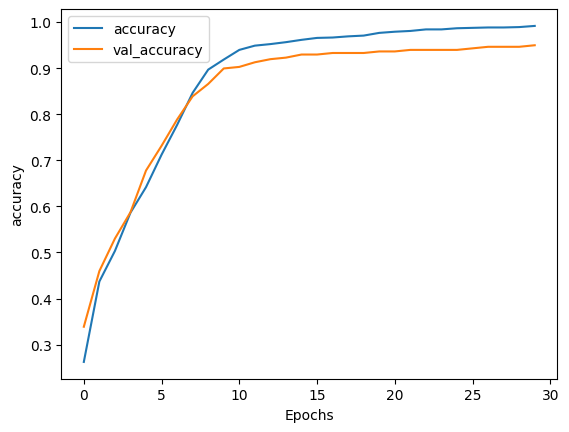

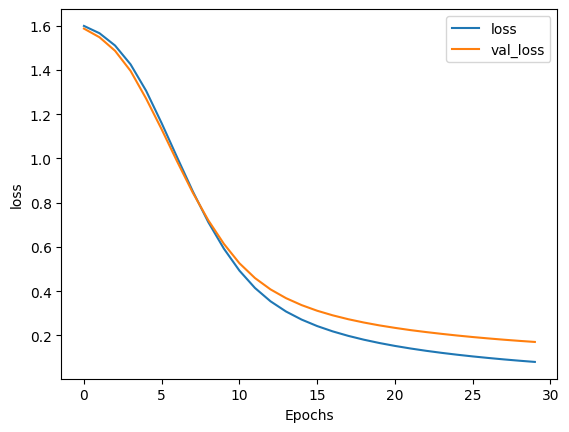

In [24]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
print('Name:JEEVAGOWTHAM S    Register Number:212222230053 ')
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")